<a href="https://colab.research.google.com/github/danplotkin/PyTorchImageCaptionerTransformer/blob/main/ImageCaptionerPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architecture

The architecture for this image captioner is based on the research paper titled [CPTR: Full Transformer Network for Image Captioning
](https://arxiv.org/pdf/2101.10804) via Liu et al. (2021). Below is an image from the original paper showing the architecture:

<img src='https://media.licdn.com/dms/image/C4D12AQGA3qFX3peTbw/article-cover_image-shrink_720_1280/0/1648387317335?e=2147483647&v=beta&t=4VOpEV8ptM4B4Q0UTZJUWqv4QFQvIuCubBoQLzJazds' width='800'>



# Import Libraries

In [1]:
import os
from google.colab import userdata, drive
drive.mount('/content/drive')
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiplicativeLR

import torchvision
from torchvision import transforms

from transformers import AutoTokenizer, ViTImageProcessor, ViTModel

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

Mounted at /content/drive


# Define Configs

Below we will define the configurations that were used in the original paper.

In [2]:
# ViT Configs
VIT_PREPROCESSOR = ViTImageProcessor.from_pretrained('google/vit-base-patch16-384')
VIT_BACKBONE = ViTModel.from_pretrained('google/vit-base-patch16-384', add_pooling_layer=False)

# Tokenizer Config
TOKENIZER = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Transformer Configs
MAX_SEQ_LEN = 80
BATCH_SIZE = 40
EMBED_DIM = 768
N_HEADS = 12
DENSE_NEURONS = EMBED_DIM * 2
INITIAL_LR = 3e-5

# Training Configs
NUM_EPOCHS = 9
NUM_LAYERS = 4

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Get Data

In [3]:
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [4]:
!kaggle datasets download -d adityajn105/flickr8k
!mkdir flickr8k
!unzip -qq flickr8k.zip -d flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:52<00:00, 17.3MB/s]
100% 1.04G/1.04G [00:52<00:00, 21.1MB/s]


# Load in Data

In [5]:
IMAGE_PATH = 'flickr8k/Images'
CAPTIONS_PATH = 'flickr8k/captions.txt'

In [6]:
def preprocess_captions(caption: str) -> pd.DataFrame:
    """
    Function to preprocess captions.
    """
    caption = caption.replace('"', '')
    caption = caption.replace("'", "")
    caption = caption.strip()
    if caption[-1] != ".":
        caption += "."
    caption = " ".join(word.lower() for word in caption.split())
    return caption


def create_mappings(captions_path: str, images_path: str) -> dict[str, list[str]]:
    """
    Function to create mappings from images to captions.
    """
    # Load in text doc
    with open(captions_path) as f:
        next(f)
        doc = f.read()

    # create dictionary
    mapping = {}
    images_to_delete = []
    for line in tqdm(doc.split('\n')):
        split = line.split(',')
        if len(split) >= 2:
            # split image with description
            image, description = split[0], ",".join(split[1:])
            description = preprocess_captions(description)
            image = os.path.join(IMAGE_PATH, image)

            # remove images with small captions
            if len(description.split()) < 5:
                images_to_delete.append(image)

            # add images into dictionary
            if image not in mapping:
                mapping[image] = []
            mapping[image].append(description)

            # delete images that had short captions
            for img in images_to_delete:
                if img in mapping:
                    del mapping[img]

    return mapping


mappings = create_mappings(CAPTIONS_PATH, IMAGE_PATH)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [7]:
len(mappings)

7801

# Preprocess Data

## Create Train-Validation Sets

In [8]:
def train_val_mapping_split(
        mapping: dict[str, list[str]],
        train_size: float = 0.8,
        shuffle: bool = True
    ) -> tuple[list[str, str], list[str, str]]:

    image_paths = list(mapping.keys())

    if shuffle:
        np.random.shuffle(image_paths)

    split = int(len(image_paths) * train_size)

    train_list = [(key, mapping[key]) for key in image_paths[:split]]
    valid_list = [(key, mapping[key]) for key in image_paths[split:]]

    # Flatten lists
    flatten_list = lambda x: [(image_path, caption) for image_path, captions in x for caption in captions]
    train_list, valid_list = flatten_list(train_list), flatten_list(valid_list)

    # Shuffle
    if shuffle:
        np.random.shuffle(train_list)
        np.random.shuffle(valid_list)

    return train_list, valid_list

In [9]:
train_list, valid_list = train_val_mapping_split(mappings)
print(f'Number of training examples: {len(train_list)}')
print(f'Number of validation examples: {len(valid_list)}')

Number of training examples: 31200
Number of validation examples: 7805


## Define ViT Transforms

In [10]:
def apply_vit_transforms(image, return_tensors='pt'):
    return VIT_PREPROCESSOR(image, return_tensors=return_tensors)['pixel_values'].squeeze(0)


transformations = {
    'train': transforms.Compose([
        transforms.Resize((VIT_PREPROCESSOR.size['height'], VIT_PREPROCESSOR.size['width'])),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=VIT_PREPROCESSOR.image_mean,
            std=VIT_PREPROCESSOR.image_std
        ),
        transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-15, 15))], p=0.4),
        transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=.3, hue=.1)], p=0.3),
        transforms.RandomApply(transforms=[transforms.GaussianBlur(kernel_size=(5, 9))], p=0.3),
    ]),
    'valid': apply_vit_transforms,
    'inverse_normalize': transforms.Normalize(
        mean=-torch.tensor(VIT_PREPROCESSOR.image_mean)/torch.tensor(VIT_PREPROCESSOR.image_std),
        std=1/torch.tensor(VIT_PREPROCESSOR.image_std)
    )
}

## Build Custom Dataset

In [11]:
class Flickr8kDataset(Dataset):
    def __init__(self, dataset: list[str, str], transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, captions = self.dataset[idx]

        # Preprocess image
        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Preprocess text
        captions = TOKENIZER.encode(captions, return_tensors='pt').flatten()
        input_text = captions[:-1]
        target_text = captions[1:]

        # Pad to max length
        input_text = F.pad(input_text, (0, MAX_SEQ_LEN - len(input_text)), value=0)
        target_text = F.pad(target_text, (0, MAX_SEQ_LEN - len(target_text)), value=0)
        return (image, input_text), target_text

In [12]:
train_dataset = Flickr8kDataset(train_list, transform=transformations['train'])
valid_dataset = Flickr8kDataset(valid_list, transform=transformations['valid'])

We will print some images with the input and target captions to validate our preprocessing

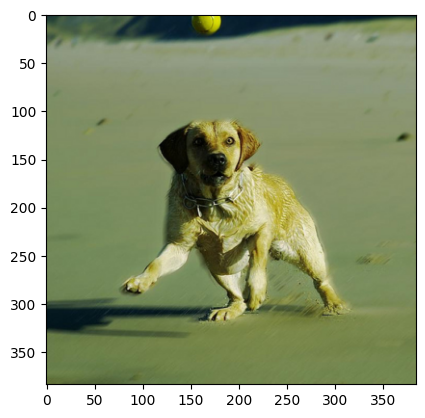

Input Text: [CLS] a gold dog is on the beach and is looking at the tennis ball in the air.
Target Text: a gold dog is on the beach and is looking at the tennis ball in the air. [SEP]


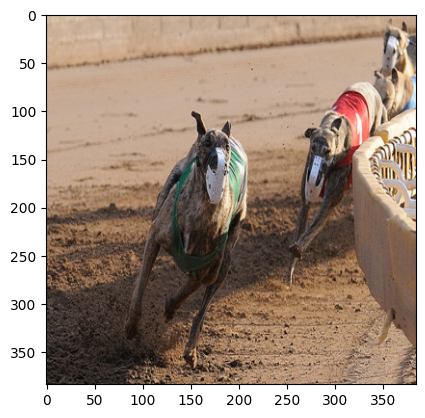

Input Text: [CLS] greyhounds race on a sandy track with the dog in green taking the lead.
Target Text: greyhounds race on a sandy track with the dog in green taking the lead. [SEP]


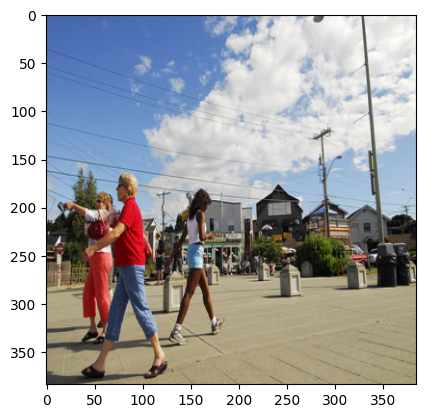

Input Text: [CLS] women walking beneath a blue sky and powerlines.
Target Text: women walking beneath a blue sky and powerlines. [SEP]


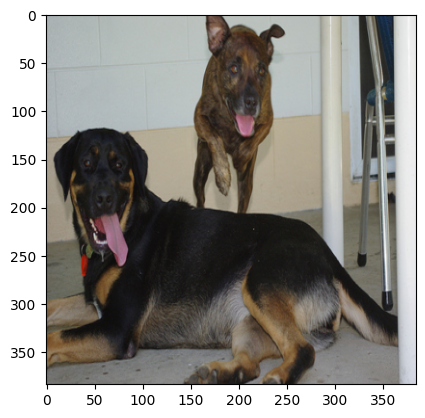

Input Text: [CLS] a black dog lies on the floor while a brown dog stands behind him.
Target Text: a black dog lies on the floor while a brown dog stands behind him. [SEP]


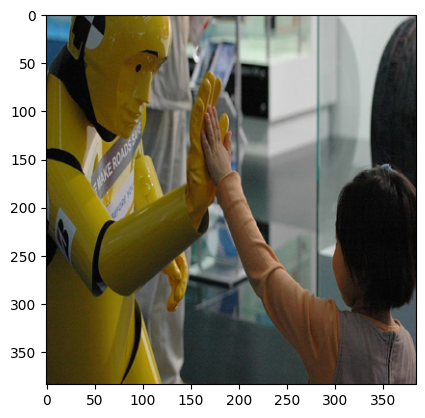

Input Text: [CLS] a little girl high - fives a yellow robot.
Target Text: a little girl high - fives a yellow robot. [SEP]


In [13]:
# Print image with captions
i = 0
for (image, input_text), target_text in valid_dataset:
    image = transformations['inverse_normalize'](image)
    plt.imshow(image.permute(1, 2, 0))
    plt.show()
    print(f'Input Text: {" ".join([token for token in TOKENIZER.decode(input_text.tolist()).split() if token != "[PAD]"])}')
    print(f'Target Text: {" ".join([token for token in TOKENIZER.decode(target_text.tolist()).split() if token != "[PAD]"])}')
    i +=1
    if i == 5:
        break

## Batch into DataLoaders

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# Validate shapes
print('Train shapes:')
for (image, input_text), target_text in train_loader:
    print(image.shape)
    print(input_text.shape)
    print(target_text.shape)
    break

print('\nVal shapes:')
for (image, input_text), target_text in valid_loader:
    print(image.shape)
    print(input_text.shape)
    print(target_text.shape)
    break

Train shapes:
torch.Size([40, 3, 384, 384])
torch.Size([40, 80])
torch.Size([40, 80])

Val shapes:
torch.Size([40, 3, 384, 384])
torch.Size([40, 80])
torch.Size([40, 80])


# Design CPTR Layers

## ViT Backbone

As the architecture says, we will be using a pretrained ViT as our image encoder. This will allow our encoder to process our images as 1D 16x16 patches.

In [16]:
class ViTBackbone(nn.Module):
    def __init__(self, freeze_params: bool = True):
        super(ViTBackbone, self).__init__()
        self.backbone = VIT_BACKBONE
        if freeze_params:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print('Frozen ViT backbone')

    def forward(self, x):
        return self.backbone(x).last_hidden_state

## Positional Embedding Layer

We will create a custom module for our decoder embeddings. Along with token embeddings via `nn.Embeddings`, we need to add positional encodings as well to understand the sequential positioning of each token. To do this, we will create a `SinusodialPositionalEncodings` layer that implements the sinusodial positional encodings formula from the original [Attention is All You Need](https://arxiv.org/pdf/1706.03762) paper:

$$ PE(pos, 2i) = sin\left(\frac{pos}{10000^{2i/d}}\right) $$

$$ PE(pos, 2i+1) = cos\left(\frac{pos}{10000^{2i/d}}\right) $$

where:
- $PE$ is the positional encoding
- $pos$ is the position
- $i$ is the dimension
- $d$ is the total number of dimensions

These encodings will be added to our token embeddings from outputs of our `nn.Embeddings` forward pass.

In [17]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(SinusoidalPositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class PositionalEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_len):
        super(PositionalEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.positional_encoding = SinusoidalPositionalEncoding(embedding_dim, max_len)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        return x

## Decoder

In [18]:
decoder_layer = nn.TransformerDecoderLayer(
    d_model=EMBED_DIM,
    nhead=N_HEADS,
    dim_feedforward=DENSE_NEURONS,
    batch_first=True
)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=NUM_LAYERS)

# Define Model

We will now define the our final CPTR model based on the architecture we are implementing from.

In [19]:
class CPTR(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_len):
        super(CPTR, self).__init__()
        self.backbone = ViTBackbone()
        self.positional_embedding = PositionalEmbedding(vocab_size, embedding_dim, max_len)
        self.decoder = decoder
        self.fc = nn.Linear(EMBED_DIM, vocab_size)

    def forward(self, inputs):
        image, input_text = inputs

        # Compute masks
        tgt_key_padding_mask = self.compute_padding_mask(input_text)
        tgt_mask = self.compute_causal_mask(input_text)

        # Encode image
        image = self.backbone(image)

        # Embed text and compute padding mask
        input_text = self.positional_embedding(input_text)

        # Decode text
        output = self.decoder(
            input_text,
            image,
            tgt_key_padding_mask=tgt_key_padding_mask,
            tgt_mask=tgt_mask,
            tgt_is_causal=True
        )

        # Fully connected head
        output = self.fc(output)
        return output

    def compute_padding_mask(self, x):
        return x.eq(0)

    def compute_causal_mask(self, x):
        seq_len = x.size(1)
        mask = torch.triu(torch.ones((seq_len, seq_len)), diagonal=1).bool()
        return mask.to(x.device)

We will intialize the following classes:
- model: Our image captioner model.
- optimizer: Our Adam optimizer.
- scheduler: Our scheduler that decays by 0.5 on the last two epochs (as mentioned in the paper).
- criterion: Our loss function, masking zeros in the calculations.



In [20]:
model = CPTR(
    vocab_size=TOKENIZER.vocab_size,
    embedding_dim=EMBED_DIM,
    max_len=MAX_SEQ_LEN
)

model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)
lmbda = lambda epoch: 0.5 if epoch >= NUM_EPOCHS - 2 else 1.0
scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)
criterion = nn.CrossEntropyLoss(ignore_index=0)

Frozen ViT backbone


# Train

We will create a `Trainer` class to implement our training loop.

In [21]:
def masked_accuracy(output, target):
    mask = target.ne(0)
    output = output.argmax(-1).masked_select(mask)
    target = target.masked_select(mask)
    return (output == target).float().mean()

In [22]:
class Trainer:
    def __init__(self, model, optimizer, scheduler, criterion, device, output_path):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []
        self.best_loss = float('inf')
        self.best_epoch = 0
        self.best_model = None
        self.device = device
        self.scheduler = scheduler
        self.output_path = output_path

    def train(self, train_loader, valid_loader, num_epochs, save_model):
        self.train_losses.clear()
        self.valid_losses.clear()
        self.train_accuracies.clear()
        self.valid_accuracies.clear()
        for i in range(num_epochs):
            epoch = i + 1
            print(f'Epoch {epoch}/{num_epochs}:')
            train_loss, train_acc = self._train_epoch(train_loader)
            valid_loss, valid_acc = self._valid_epoch(valid_loader)

            # Step the scheduler
            self.scheduler.step()

            # Append history
            self.train_losses.append(train_loss)
            self.valid_losses.append(valid_loss)
            self.train_accuracies.append(train_acc)
            self.valid_accuracies.append(valid_acc)

            # Check loss progress
            if valid_loss < self.best_loss:
                self.best_loss = valid_loss
                self.best_epoch = epoch
                self.best_model = self.model.state_dict()
                print(f'Best model updated at epoch {epoch}')

            print()

        self.model.load_state_dict(self.best_model)
        # Save model
        model_dir = os.path.dirname(self.output_path)
        print(f'Best model restored at epoch {self.best_epoch}')

        if save_model:
            try:
                if not os.path.exists(model_dir):
                    os.makedirs(model_dir)
                self.save_model(self.output_path)
                print(f'Saved model to {model_dir}')
            except Exception as e:
                print(f'Error saving model: {e}')

        return {
            'best_model': self.best_model,
            'history': {
                'train_losses': self.train_losses,
                'valid_losses': self.valid_losses,
                'train_accuracies': self.train_accuracies,
                'valid_accuracies': self.valid_accuracies
            }
        }

    def evaluate(self, test_loader):
        return self._valid_epoch(test_loader)

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def _train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0
        running_acc = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, items in pbar:
            batch_num = i + 1
            (image, input_text), target_text = items
            self.optimizer.zero_grad()

            image, input_text, target_text = image.to(self.device), input_text.to(self.device), target_text.to(self.device)
            output = self.model((image, input_text))

            loss = self.criterion(output.view(-1, output.shape[-1]), target_text.view(-1))
            loss.backward()
            self.optimizer.step()

            running_acc += masked_accuracy(output, target_text).item()
            running_loss += loss.item()

            train_loss = running_loss / (batch_num)
            train_acc = running_acc / (batch_num)
            pbar.set_description(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        return train_loss, train_acc

    @torch.no_grad()
    def _valid_epoch(self, valid_loader):
        self.model.eval()
        running_loss = 0
        running_acc = 0
        pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for i, items in pbar:
            batch_num = i + 1
            (image, input_text), target_text = items
            image, input_text, target_text = image.to(self.device), input_text.to(self.device), target_text.to(self.device)
            output = self.model((image, input_text))
            loss = self.criterion(output.view(-1, output.shape[-1]), target_text.view(-1))
            running_acc += masked_accuracy(output, target_text).item()
            running_loss += loss.item()
            valid_loss = running_loss / (batch_num)
            valid_acc = running_acc / (batch_num)
            pbar.set_description(f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

        return valid_loss, valid_acc

We will now train our model.

In [23]:
output_path = '/content/drive/MyDrive/Models/CPTR_PyTorch/cptr.pt'
trainer = Trainer(model, optimizer, scheduler, criterion, DEVICE, output_path)
training_dict = trainer.train(
    train_loader,
    valid_loader,
    NUM_EPOCHS,
    save_model=True
)

Epoch 1/9:


  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Best model updated at epoch 1

Epoch 2/9:


  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Best model updated at epoch 2

Epoch 3/9:


  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Best model updated at epoch 3

Epoch 4/9:


  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Best model updated at epoch 4

Epoch 5/9:


  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Best model updated at epoch 5

Epoch 6/9:


  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Best model updated at epoch 6

Epoch 7/9:


  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Best model updated at epoch 7

Epoch 8/9:


  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Best model updated at epoch 8

Epoch 9/9:


  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Best model updated at epoch 9

Best model restored at epoch 9
Saved model to /content/drive/MyDrive/Models/CPTR_PyTorch


# Evaluate Model

## Evaluate Validation Loader

In [24]:
_ = trainer.evaluate(valid_loader)

  0%|          | 0/196 [00:00<?, ?it/s]

## Plot Loss and Accuracy during Training

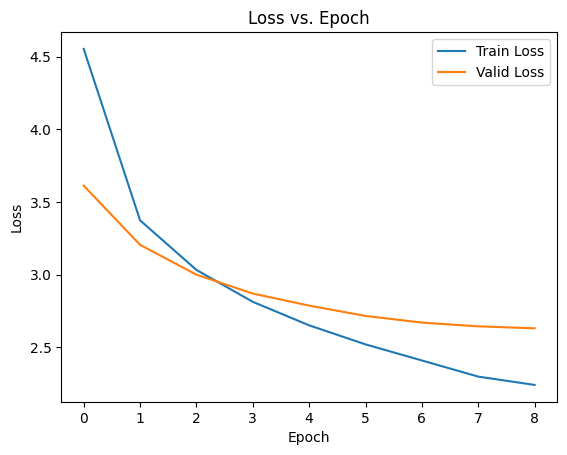

In [27]:
history = training_dict['history']
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['valid_losses'], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

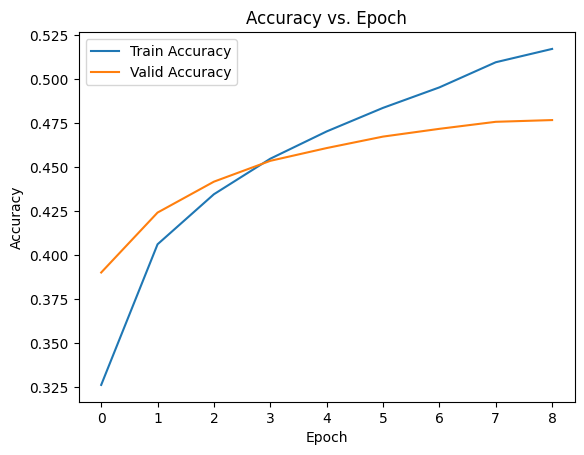

In [28]:
plt.plot(history['train_accuracies'], label='Train Accuracy')
plt.plot(history['valid_accuracies'], label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

# Generate Captions

We will make a custom module that will use autoregression to generate captions with our models. Rather than using a greedy search method, the paper uses beam search inference, with a beam size of 3. We will implement a generator that can do both beam search and greedy search.

In [104]:
class CaptionGenerator(nn.Module):
    def __init__(self, model, tokenizer, max_length, device, transform=None):
        super(CaptionGenerator, self).__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device
        self.transform = transform
        self = self.to(device)

    @torch.no_grad()
    def forward(self, image, plot_image=False, search_mode='greedy', beam_size=None):
        self.model.eval()
        if plot_image:
            plt.axis('off')
            plt.imshow(image)
            plt.show()
        # Get image embeddings
        img_embeddings = self.encode(image)
        # Decode
        if search_mode == 'greedy':
            return self.decode_greedy(img_embeddings)
        elif search_mode == 'beam':
            return self.decode_beam(img_embeddings, beam_size)
        else:
            raise ValueError("Unsupported search mode. Choose either 'greedy' or 'beam'.")

    @torch.no_grad()
    def encode(self, image):
        self.model.eval()
        if self.transform is not None:
            image = self.transform(image)
            image = image.to(self.device)
        if not isinstance(image, torch.Tensor):
            image = torch.tensor(image, dtype=torch.float32, device=self.device)
        image = image.unsqueeze(0)
        image_embeddings = self.model.backbone(image)
        return image_embeddings

    @torch.no_grad()
    def predict_next_token(self, tokens, image_embeddings):
        self.model.eval()
        word_embeddings = self.model.positional_embedding(tokens)
        output = self.model.decoder(
            word_embeddings,
            image_embeddings,
            tgt_key_padding_mask=self.model.compute_padding_mask(tokens),
            tgt_mask=self.model.compute_causal_mask(tokens),
            tgt_is_causal=True
        )
        preds = self.model.fc(output)
        preds = preds[:, -1, :]
        return preds

    @torch.no_grad()
    def decode_greedy(self, image_embeddings):
        self.model.eval()
        initial = torch.tensor([[self.tokenizer.cls_token_id]], dtype=torch.long, device=self.device)
        tokens = initial
        for i in range(self.max_length):
            next_token_logits = self.predict_next_token(tokens, image_embeddings)
            next_token = next_token_logits.argmax(-1).unsqueeze(0)
            tokens = torch.cat([tokens, next_token], dim=1)
            if tokens[..., -1] == self.tokenizer.sep_token_id:
                break
        decoded_text = self.tokenizer.decode(tokens.squeeze().tolist())
        decoded_text = decoded_text.replace(self.tokenizer.cls_token, '').replace(self.tokenizer.sep_token, '')
        return decoded_text.strip().capitalize()

    @torch.no_grad()
    def decode_beam(self, image_embeddings, beam_size):
        self.model.eval()
        initial = torch.tensor([[self.tokenizer.cls_token_id]], dtype=torch.long, device=self.device)
        sequences = [[initial, 0]]  # [tokens, log_prob]

        for _ in range(self.max_length):
            all_candidates = []
            for seq, score in sequences:
                if seq[0][-1] == self.tokenizer.sep_token_id:
                    all_candidates.append((seq, score))
                    continue
                next_token_logits = self.predict_next_token(seq, image_embeddings)
                next_token_log_probs = F.log_softmax(next_token_logits, dim=-1)
                topk_log_probs, topk_indices = next_token_log_probs.topk(beam_size)

                for i in range(beam_size):
                    candidate = [torch.cat([seq, topk_indices[:, i].unsqueeze(0)], dim=1), score + topk_log_probs[0, i].item()]
                    all_candidates.append(candidate)

            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:beam_size]

        best_sequence = sequences[0][0]
        decoded_text = self.tokenizer.decode(best_sequence.squeeze().tolist())
        decoded_text = decoded_text.replace(self.tokenizer.cls_token, '').replace(self.tokenizer.sep_token, '')
        return decoded_text.strip().capitalize()

We will create a function to get random validation images, which we will use to generate captions. We will use beam search with a beam size of 3.

In [108]:
def get_random_val_image():
    random_idx = np.random.randint(0, len(valid_dataset) - 1)
    image, _ = valid_list[random_idx]
    return Image.open(image)

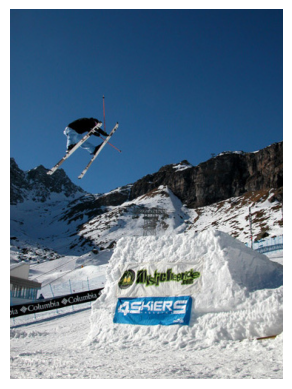

Caption: A snowboarder jumps over a snowy hill.



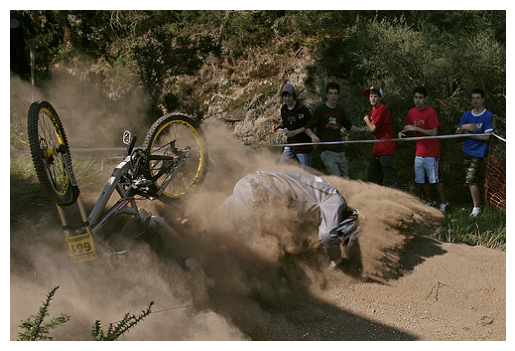

Caption: A dirt bike rider is jumping off a ramp.



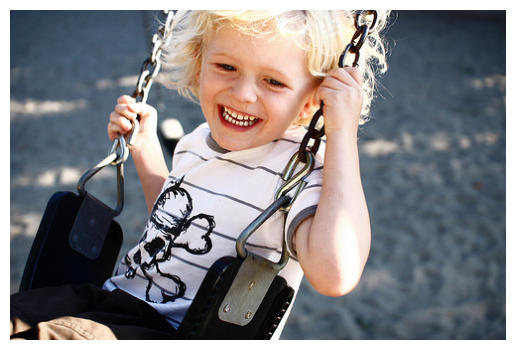

Caption: A little girl is swinging on a swing.



In [115]:
captioner = CaptionGenerator(
    model,
    TOKENIZER,
    MAX_SEQ_LEN,
    DEVICE,
    transform=transformations['valid']
)

for _ in range(3):
    image = get_random_val_image()
    caption = captioner(image, plot_image=True, search_mode='beam', beam_size=3)
    print(f'Caption: {caption}\n')